In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
data_df = pd.read_csv('Activity3.csv', header = None)

In [4]:
data_df.head()
print(len(data_df))

59


In [5]:
t, y, yerr = data_df[0], data_df[1], data_df[2]
exp_t = np.exp(t/100)

#### y = $a_1 e^{-a_2 t} + b_1 e^{-b_2 t} + c_1 t$
#### t = log(x)   or,   $x = e^t$, but taken as $x = e^{t/100}$ (to rescale so $e^{800}$ doesn't return inf)
#### y = $a_1 e^{-100 a_2 log(x)} + b_1 e^{-100 b_2 log(x)} + 100 c_1 log(x) + c_2$
#### y = $a_1 x^{-100 a_2} + b_1 x^{-100 b_2} + 100 c_1 log(x) + c_2$

## Using iminuit

In [14]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
from scipy import stats

In [12]:
least_squares = LeastSquares(exp_t, y, yerr, fit_func)
m = Minuit(least_squares, a1=100, a2=0.5, b1=100, b2=1, c1=1)

m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 69.05 (χ²/ndof = 1.3)      │              Nfcn = 449              │
│ EDM = 6.33e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │    128    │    18     │            │            │         │         │       │
│ 1 │ a2   │   0.40    │   0.05    │            │            │         │         │       │
│ 2 │ b1   │    960    │    50     │            │            │         │         │       │
│ 3 │ b2   │   2.85    │   0.21    │            │            │         │         │       │
│ 4 │ c1   │   0.99    │   0.25    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────┐
│    │       a1       a2       b1       b2       c1 │
├────┼──────────────────────────────────────────────┤
│ a1 │      342   0.8961   0.17e3     3.03     3.53 │
│ a2 │   0.8961  0.00257   0.3291   0.0074   0.0111 │
│ b1 │   0.17e3   0.3291 2.46e+03     6.57     0.81 │
│ b2 │     3.03   0.0074     6.57   0.0423     0.03 │
│ c1 │     3.53   0.0111     0.81     0.03   0.0621 │
└────┴──────────────────────────────────────────────┘

<ValueView a1=128.3247844969397 a2=0.40414339069270167 b1=956.1125935378817 b2=2.849740155584235 c1=0.9881884477538007>


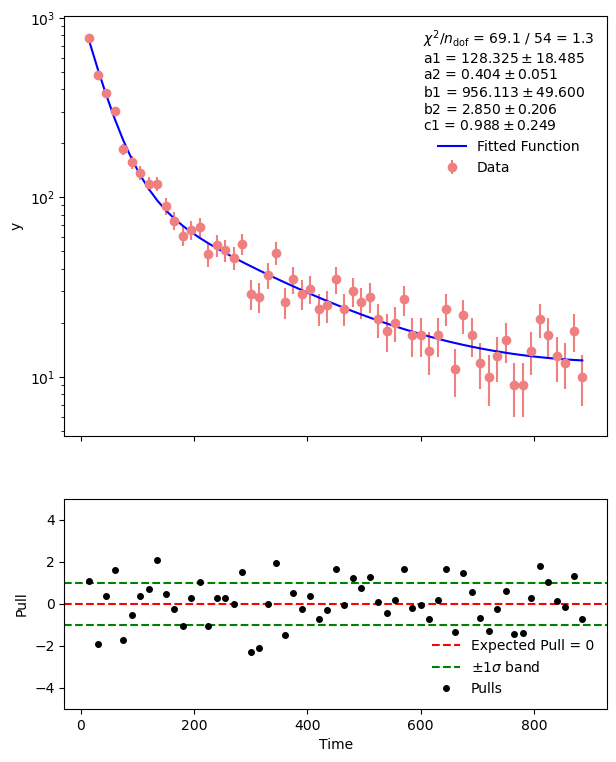

In [47]:
fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=True, sharey=False,
        figsize=(7, 9),
        gridspec_kw={'height_ratios':[2,1]}
        )

axes[0].errorbar(t, y, yerr, color='lightcoral', fmt = 'o', label = 'Data')
axes[0].plot(t, fit_func(exp_t, *m.values), color='blue', label='Fitted Function')
axes[0].set_yscale("log")
axes[0].set_ylabel("y")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

axes[0].legend(title="\n".join(fit_info), frameon=False)
print(m.values)

pulls = (y - fit_func(exp_t, *m.values)) / yerr
axes[1].errorbar(t, pulls, fmt='o', color='black', markersize=4, label='Pulls')
axes[1].axhline(0, color='red', linestyle='--', label='Expected Pull = 0')
axes[1].axhline(1, color='green', linestyle='--', label='$\pm 1\sigma$ band')
axes[1].axhline(-1, color='green', linestyle='--')
axes[1].set_ylim(-5, 5)
axes[1].set_ylabel('Pull')
axes[1].set_xlabel('Time')
axes[1].legend(frameon = False)

In [21]:
#P-VALUE

chi2 = m.fval
n_dof = m.ndof
pvalue = 1 - stats.chi2.cdf(chi2, n_dof) #right tail of chi2 distribution
print(pvalue) #0.08 > 0.05, so follows the null hypothesis i.e, model and data have good agreements

0.08149058515121865
